# 传统图像分类网络架构

In [1]:
import torch as t
import torchvision as tv
from torch import Tensor
from torch.nn import  Module
import cv2
import numpy as np
model = tv.models.squeezenet1_1(True)
model.eval()
print(model.__str__())

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

c:\dev\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\dev\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


为什么叫resnet18，将权重层提出来，刚刚好是18层

In [2]:
for name,_ in model.named_parameters():
    if name.find("conv")!=-1 or name.find("fc")!=-1:
        print(name)

# 注册钩子，获取卷积层的输出

In [3]:
features=[]

def hook_features(module:Module,input:Tensor,output:Tensor):
    features.append(output.detach().numpy())


# 注册钩子
model._modules.get("features").register_forward_hook(hook_features)



# 将图片丢入网络中

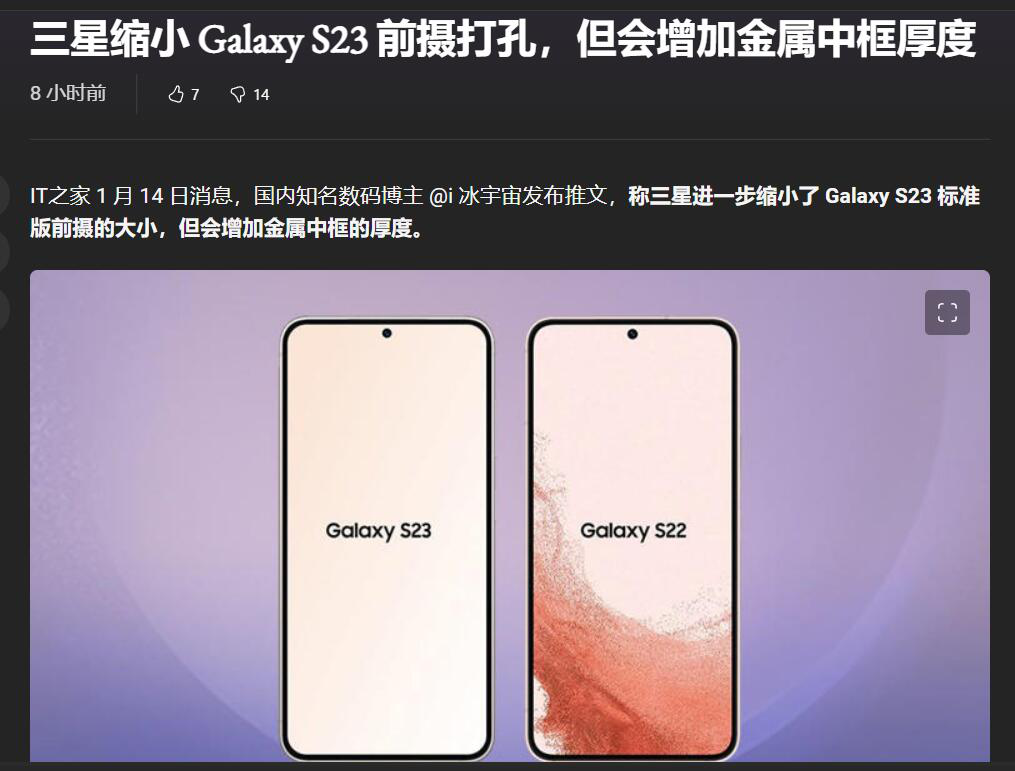

In [4]:
# 归一化
normalize = tv.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess =  tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
    normalize
])
import PIL.Image
img = PIL.Image.open(r"C:\Users\shiku\Desktop\test.jpg")

img

In [5]:
# 丢到神经网络中，获得分类结果

img_tensor = preprocess.__call__(img)
img_tensor=img_tensor.unsqueeze(0)

img_tensor.shape
# B C H W

torch.Size([1, 3, 224, 224])

In [6]:
logit = model.forward(img_tensor)

logit.shape

torch.Size([1, 1000])

# 获得1000类的标签

In [7]:
# load the imagenet category list
import json
LABELS_file=r"imagenet-simple-labels.json"
with open(LABELS_file) as f:
    classes = json.load(f)

classes

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'water snake',
 'vin

In [8]:
# 获取各类的概率
import torch.nn.functional as F
softmax_logit =  F.softmax(logit,1).squeeze()

print(softmax_logit.shape)

probs,idx = softmax_logit.sort(0,True)

# 输出结果
for i in range(0, 5):
    print(
        '{:.3f} -> {}, logit is {}'.format(probs[i], classes[idx[i]], logit[0][idx[i]]))


torch.Size([1000])
0.553 -> website, logit is 18.623239517211914
0.099 -> CRT screen, logit is 16.903244018554688
0.045 -> perfume, logit is 16.121936798095703
0.039 -> dust jacket, logit is 15.968358039855957
0.032 -> automated teller machine, logit is 15.758218765258789


In [9]:
out_feature = features[0].squeeze()
out_feature.shape

(512, 13, 13)

# 提取线性层参数进行点乘

In [10]:
params = list(model.parameters())
weight_softmax = params[-2].detach().squeeze()

weight_softmax.shape

torch.Size([1000, 512])

In [11]:
# 将类别最大的那个下标提取出来
print(idx[0])

weight_max_prob = weight_softmax[idx[0]]

weight_max_prob.shape

tensor(916)


torch.Size([512])

In [12]:
pooling_map = F.adaptive_avg_pool2d(t.tensor(out_feature).unsqueeze(0), (1, 1)).squeeze(0)
print(pooling_map.shape)
class_activation_mapping = (pooling_map*weight_max_prob.unsqueeze(1).unsqueeze(1)).squeeze()
values,idx_max_prob=class_activation_mapping.sort(0,True)

for i in range(10):
    print(
        f"max idx = {idx_max_prob[i]}, the value is {values[i]},the weight value is {weight_max_prob[idx_max_prob[i]]}")


torch.Size([512, 1, 1])
max idx = 94, the value is 2.466796636581421,the weight value is 0.11311592906713486
max idx = 237, the value is 2.007904529571533,the weight value is 0.11650454998016357
max idx = 213, the value is 1.6007145643234253,the weight value is 0.09927386790513992
max idx = 35, the value is 1.4110069274902344,the weight value is 0.10585170239210129
max idx = 494, the value is 1.3680801391601562,the weight value is 0.09008815139532089
max idx = 361, the value is 1.0260745286941528,the weight value is 0.10088381916284561
max idx = 87, the value is 0.8664002418518066,the weight value is 0.0989074632525444
max idx = 131, the value is 0.816354513168335,the weight value is 0.05931076779961586
max idx = 263, the value is 0.5562346577644348,the weight value is 0.08925584703683853
max idx = 155, the value is 0.5053811073303223,the weight value is 0.02684422768652439


In [13]:
cam=out_feature[idx_max_prob[0]]
print(cam)
cam = cam - np.min(cam)
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
cv2.imshow("123,",cv2.applyColorMap(cv2.resize(cam_img, img.size), cv2.COLORMAP_JET))
cv2.waitKey()
cv2.exit()

[[ 0.         0.        22.218569  29.11945   17.995302   9.368592
  11.062952  17.87497   14.628973   4.5373306  0.        10.91801
  18.143042 ]
 [ 3.77825    0.         7.131088  13.601396  24.942352  23.96645
  25.43916   29.460798  24.818556  21.038132  16.799425  16.58897
  45.90905  ]
 [27.71512    9.271017   0.         8.991834  12.39335   14.39854
  11.633914  23.655336  19.556616  12.832208   6.7380056 13.006443
  16.774067 ]
 [24.664207   5.621454   0.         0.        15.600625  18.011007
  18.524689  18.524252  17.779148  12.414517   8.363248  11.541525
   2.306652 ]
 [36.640717  21.673986   6.714402   0.         0.         0.
   0.         0.         0.         0.         0.        18.6153
   0.       ]
 [49.5398    43.79043    6.305286   0.         0.         0.
   0.         0.         0.         0.         0.        15.52168
  18.345434 ]
 [42.831463  24.69851    5.3352194  0.         0.         0.
   4.414251   0.         0.         0.         1.9108214 15.703847
  4